In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("./data/mnist_train.csv")
df2 = pd.read_csv("./data/mnist_test.csv")

In [3]:
y_train = df.pop("label").to_numpy()
x_train = df.to_numpy()

In [4]:
y_test = df2.pop("label").to_numpy()
x_test = df2.to_numpy()

In [5]:
x_train = x_train.T
y_train = y_train.T
x_test = x_test.T
y_test = y_test.T

## 🏗️ Model Architecture

---

## 📥 Input Layer

- **Input size:** 784  
- Each MNIST image is **28 × 28 pixels**
- Images are flattened into a 1D vector
- Pixel values are normalized before training

---

## 🔵 Hidden Layer 1

- **Number of units:** 128  
- **Computation:**  
  - Linear transformation: `Z₁ = W₁X + b₁`
  - Activation: **ReLU**
- Learns basic features such as edges and strokes

---

## 🔵 Hidden Layer 2

- **Number of units:** 64  
- **Computation:**  
  - Linear transformation: `Z₂ = W₂A₁ + b₂`
  - Activation: **ReLU**
- Learns higher-level digit patterns

---

## 🎯 Output Layer

- **Number of units:** 10  
- One unit per digit class (`0–9`)
- **Activation function:** **Softmax**
- Outputs class probabilities

---


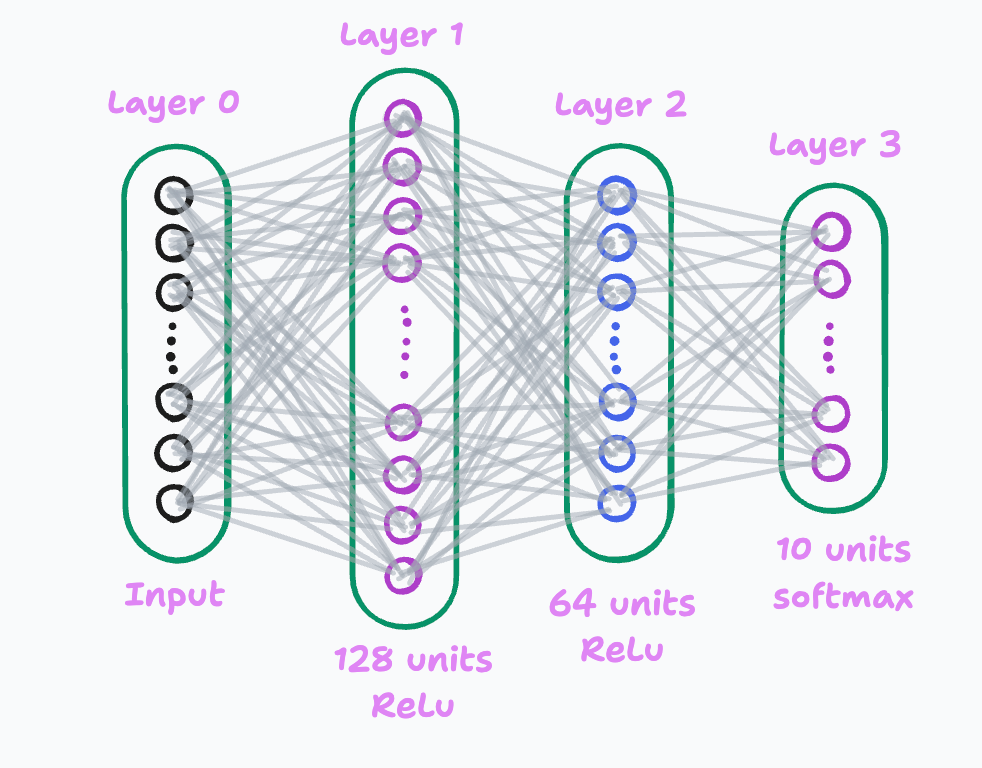

In [6]:
def initialize_params():
    W1 = np.random.randn(128, 784) * 0.01
    b1 = np.zeros((128, 1))
    W2 = np.random.randn(64, 128) * 0.01
    b2 = np.zeros((64, 1))
    W3 = np.random.randn(10, 64) * 0.01
    b3 = np.zeros((10, 1))
    return W1, b1, W2, b2, W3, b3

In [7]:
def ReLu(Z):
  return np.maximum(Z, 0)

In [8]:
def softmax(Z):
    exp = np.exp(Z - np.max(Z, axis=0, keepdims=True))
    return exp / np.sum(exp, axis=0, keepdims=True)

## 🧮 Forward Propagation

- Z₁ = W₁X + b₁
- A₁ = ReLU(Z₁)

- Z₂ = W₂A₁ + b₂
- A₂ = ReLU(Z₂)

- Z₃ = W₃A₂ + b₃
- A₃ = Softmax(Z₃)

In [9]:
def forward_prop(X, W1, b1, W2, b2, W3, b3):
  Z1 = np.dot(W1, X) + b1
  A1 = ReLu(Z1)
  Z2 = np.dot(W2, A1) + b2
  A2 = ReLu(Z2)
  Z3 = np.dot(W3, A2) + b3
  A3 = softmax(Z3)
  return Z1, A1, Z2, A2, Z3, A3


In [10]:
def one_hot_encode(Y):
  one_hot_Y = np.zeros((Y.shape[0], Y.max() + 1))
  one_hot_Y[np.arange(Y.size), Y] = 1
  return one_hot_Y.T

## 🔙 Backward Propagation

- dZ₃ = A₃ − Y
- dW₃ = (1 / m) · dZ₃ · A₂ᵀ
- db₃ = (1 / m) · sum(dZ₃)

- dA₂ = W₃ᵀ · dZ₃
- dZ₂ = dA₂ ⊙ ReLU’(Z₂)
- dW₂ = (1 / m) · dZ₂ · A₁ᵀ
- db₂ = (1 / m) · sum(dZ₂)

- dA₁ = W₂ᵀ · dZ₂
- dZ₁ = dA₁ ⊙ ReLU’(Z₁)
- dW₁ = (1 / m) · dZ₁ · Xᵀ
- db₁ = (1 / m) · sum(dZ₁)

In [11]:
def back_prop(X, Y, A1, A2, A3, Z1, Z2, Z3, W2, W3):
  m = Y.shape[0]
  dZ3 = A3 - one_hot_encode(Y)
  dW3 = 1 / m * np.dot(dZ3, A2.T)
  db3 = 1 / m * np.sum(dZ3, axis=1, keepdims=True)
  dZ2 = np.dot(W3.T, dZ3) * (Z2 > 0)
  dW2 = 1 / m * np.dot(dZ2, A1.T)
  db2 = 1 / m * np.sum(dZ2, axis=1, keepdims=True)
  dZ1 = np.dot(W2.T, dZ2) * (Z1 > 0)
  dW1 = 1 / m * np.dot(dZ1, X.T)
  db1 = 1 / m * np.sum(dZ1, axis=1, keepdims=True)

  return dW3, db3, dW2, db2, dW1, db1

In [12]:
def update_params(W1, b1, W2, b2, W3, b3, dW1, db1, dW2, db2, dW3, db3, rate):
  W1 -= rate*dW1
  W2 -= rate*dW2
  W3 -= rate*dW3
  b1 -= rate*db1
  b2 -= rate*db2
  b3 -= rate*db3

  return W1, b1, W2, b2, W3, b3

In [13]:
def get_predictions(A3):
  return np.argmax(A3, 0)

In [14]:
def get_accuracy(predictions, Y):
  return np.sum(predictions == Y) / Y.shape[0]

## 📉 Loss Function

- **Categorical Cross-Entropy Loss**
- Measures prediction error between true labels and model output

In [15]:
def compute_loss(A3, Y):
    m = Y.shape[0]
    loss = -np.mean(np.log(A3[Y, np.arange(m)] + 1e-8))
    return loss

In [16]:
def predict(X, W1, b1, W2, b2, W3, b3):
  _, _, _, _, _, A3 = forward_prop(X, W1, b1, W2, b2, W3, b3)
  predictions = get_predictions(A3)
  return predictions

## 🔄 Training Procedure

1. Forward propagation  
2. Loss computation  
3. Backpropagation  
4. Gradient descent parameter updates 

In [17]:
def gradient_descent(iterations=2000, rate=0.001):
    W1, b1, W2, b2, W3, b3 = initialize_params()
    losses = [] 
    for i in range(iterations):
        Z1, A1, Z2, A2, Z3, A3 = forward_prop(x_train, W1, b1, W2, b2, W3, b3)

        loss = compute_loss(A3, y_train)
        losses.append(loss)

        dW3, db3, dW2, db2, dW1, db1 = back_prop(x_train, y_train, A1, A2, A3, Z1, Z2, Z3, W2, W3)

        W1, b1, W2, b2, W3, b3 = update_params(W1, b1, W2, b2, W3, b3, dW1, db1, dW2, db2, dW3, db3,rate)

        if i % 100 == 0:
            predictions = get_predictions(A3)
            acc = get_accuracy(predictions, y_train)
            print(f"iteration {i}: accuracy={acc:.4f}, loss={loss:.4f}")

    return W1, b1, W2, b2, W3, b3, losses

In [18]:
W1, b1, W2, b2, W3, b3, losses = gradient_descent()

iteration 0: accuracy=0.0914, loss=2.3065
iteration 100: accuracy=0.5386, loss=1.6663
iteration 200: accuracy=0.7794, loss=0.8299
iteration 300: accuracy=0.8409, loss=0.5753
iteration 400: accuracy=0.8693, loss=0.4714
iteration 500: accuracy=0.8833, loss=0.4167
iteration 600: accuracy=0.8917, loss=0.3829
iteration 700: accuracy=0.8979, loss=0.3595
iteration 800: accuracy=0.9030, loss=0.3416
iteration 900: accuracy=0.9069, loss=0.3269
iteration 1000: accuracy=0.9103, loss=0.3143
iteration 1100: accuracy=0.9136, loss=0.3031
iteration 1200: accuracy=0.9168, loss=0.2930
iteration 1300: accuracy=0.9197, loss=0.2836
iteration 1400: accuracy=0.9222, loss=0.2748
iteration 1500: accuracy=0.9247, loss=0.2665
iteration 1600: accuracy=0.9267, loss=0.2586
iteration 1700: accuracy=0.9292, loss=0.2512
iteration 1800: accuracy=0.9310, loss=0.2441
iteration 1900: accuracy=0.9333, loss=0.2375


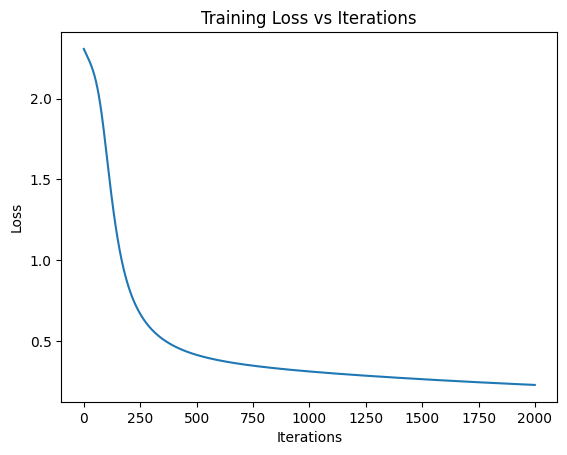

In [19]:
plt.plot(losses)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Training Loss vs Iterations")
plt.show()

In [20]:
predictions = predict(x_test, W1, b1, W2, b2, W3, b3)
print(f"Test set accuracy: {get_accuracy(predictions, y_test)}")

Test set accuracy: 0.9348


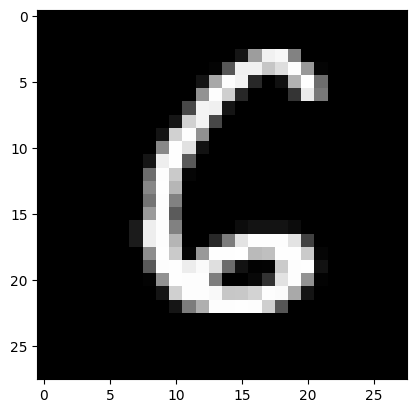

Predicted label: 6
True label: 6


In [25]:
image_index = 98
input_image = x_test[:, image_index].reshape(28,28)
plt.imshow(input_image, cmap='gray')
plt.show()
print(f"Predicted label: {predictions[image_index]}")
print(f"True label: {y_test[image_index]}")